In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import _page_width_, float_formatter
plt.rcParams['figure.figsize'] = 10,10

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.metrics as metrics

In [2]:
TRAIN_RATIO = 0.8
np.random.seed(42)

# Reciever Operating Curve (ROC) Demo

## Dataset
We use the Breast Cancer dataset from [Kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/data) and try to predict the class of the cancer.
This is an unbalanced data set, and we manipulate the data set further to make it even more unbalanced.
The data looks like that:

In [3]:
df=pd.read_csv('datasets_180_408_data.csv')
df.drop(['Unnamed: 32'],axis=1,inplace=True)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.diagnosis.value_counts()/len(df)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

Making the dataset even more imbalanced by removing 60% of malignant cases

In [5]:
df_M=df.loc[df.diagnosis=='M'].sample(frac=0.4)
df_B=df.loc[df.diagnosis=='B']

In [6]:
df=pd.concat([df_M,df_B]).sort_index().reset_index() #First sorts to previous index and then resets index to remove indices of dropped rows

In [7]:
df.head()

,index,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.1700,0.15780,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
1,9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.2396,0.22730,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750
2,12,846226,M,19.17,24.80,132.40,1123.0,0.09740,0.2458,0.20650,...,20.96,29.94,151.70,1332.0,0.1037,0.3903,0.3639,0.1767,0.3176,0.10230
3,15,84799002,M,14.54,27.54,96.73,658.8,0.11390,0.1595,0.16390,...,17.46,37.13,124.10,943.2,0.1678,0.6577,0.7026,0.1712,0.4218,0.13410
4,16,848406,M,14.68,20.13,94.74,684.5,0.09867,0.0720,0.07395,...,19.07,30.88,123.40,1138.0,0.1464,0.1871,0.2914,0.1609,0.3029,0.08216


In [8]:
df.diagnosis.value_counts()/len(df)

B    0.807692
M    0.192308
Name: diagnosis, dtype: float64

Splitting the dataset into train and test : 

In [9]:
msk = np.random.rand(len(df)) < TRAIN_RATIO
train = df[msk]
test = df[~msk]

def convert_df_Xy(df):
    X = df.drop(['diagnosis','id'],axis=1)
    y = df['diagnosis']
    le = sklearn.preprocessing.LabelEncoder().fit(y)
    y = le.transform(y)
    return X,y

X_train,y_train = convert_df_Xy(train)
X_test,y_test = convert_df_Xy(test)

We scale the values to zero mean and unit variance

In [10]:
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [11]:
clf_logreg = sklearn.linear_model.LogisticRegression().fit(X_train,y_train)
y_score_logreg = clf_logreg.predict_proba(X_test)[:,1]

threshold_logreg = 0.5
y_pred_logreg = y_score_logreg>threshold_logreg
fpr_lr, tpr_lr, thresholds = metrics.roc_curve(y_test, y_score_logreg, pos_label=1)

In [12]:
print(f"AUC : {sklearn.metrics.roc_auc_score(y_test,y_pred_logreg)}")
print(f"Accuracy Score : {sklearn.metrics.accuracy_score(y_test,y_pred_logreg)}")
print(f"Confusion Matrix : \n",sklearn.metrics.confusion_matrix(y_test,y_pred_logreg))

AUC : 0.9545454545454546
Accuracy Score : 0.978494623655914
Confusion Matrix : 
 [[71  0]
 [ 2 20]]


## K-Nearest Neighbors

In [13]:
clf_knn = sklearn.neighbors.KNeighborsClassifier().fit(X_train,y_train)
y_score_knn = clf_knn.predict_proba(X_test)[:,1]

In [14]:
threshold_knn = 0.5
y_pred_knn = y_score_knn>threshold_knn
fpr_knn, tpr_knn, thresholds = metrics.roc_curve(y_test, y_score_knn, pos_label=1)

In [15]:
print(f"AUC : {sklearn.metrics.roc_auc_score(y_test,y_pred_knn)}")
print(f"Accuracy Score : {sklearn.metrics.accuracy_score(y_test,y_pred_knn)}")
print(f"Confusion Matrix : \n",sklearn.metrics.confusion_matrix(y_test,y_pred_knn))

AUC : 0.8636363636363636
Accuracy Score : 0.9354838709677419
Confusion Matrix : 
 [[71  0]
 [ 6 16]]


## Predict Majority class (Naive Classifier)

In [16]:
y_pred_naive = np.repeat(1,y_test.shape[0])

In [17]:
print(f"AUC : {sklearn.metrics.roc_auc_score(y_test,y_pred_naive)}")
print(f"Accuracy Score : {sklearn.metrics.accuracy_score(y_test,y_pred_naive)}")
print(f"Confusion Matrix : \n",sklearn.metrics.confusion_matrix(y_test,y_pred_naive))

AUC : 0.5
Accuracy Score : 0.23655913978494625
Confusion Matrix : 
 [[ 0 71]
 [ 0 22]]


By looking at the confusion matrices we see that the problem is now, that even the stupid approach yields a
reasonable mmce performance. Thus, we need additional measure: Let’s compare the logistic regression and
the stupid learner in terms of sensitivity1 and specificity2 (check if you can compute these values by hand):

In [23]:
print(f"Confusion Matrix : \n",sklearn.metrics.classification_report(y_test,y_pred_logreg))

Confusion Matrix : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.91      0.95        22

    accuracy                           0.98        93
   macro avg       0.99      0.95      0.97        93
weighted avg       0.98      0.98      0.98        93



In [24]:
print(f"Confusion Matrix : \n",sklearn.metrics.classification_report(y_test,y_pred_naive))

Confusion Matrix : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.24      1.00      0.38        22

    accuracy                           0.24        93
   macro avg       0.12      0.50      0.19        93
weighted avg       0.06      0.24      0.09        93



/raid/anaconda3/envs/datascience/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A specificity of 0 means that all ill persons would be told they are healthy, which is certainly not what the
test is intended for. On the other hand can we do better with the logistic regression in terms of those
measures? Remember with our classification methods we try to estimate the posterior probabilities. Until
now in the case of two classes we classified the observation as the first class if its posterior probability is
greater or equal to 50% and otherwise as the second class. So what happens if we move this threshold?

In [25]:
threshold_logreg = 0.01
y_pred_logreg = y_score_logreg>threshold_logreg
print(f"Confusion Matrix : \n",sklearn.metrics.classification_report(y_test,y_pred_logreg))

Confusion Matrix : 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        71
           1       0.76      1.00      0.86        22

    accuracy                           0.92        93
   macro avg       0.88      0.95      0.91        93
weighted avg       0.94      0.92      0.93        93



In [26]:
threshold_logreg = 0.7
y_pred_logreg = y_score_logreg>threshold_logreg
print(f"Confusion Matrix : \n",sklearn.metrics.classification_report(y_test,y_pred_logreg))

Confusion Matrix : 
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        71
           1       1.00      0.77      0.87        22

    accuracy                           0.95        93
   macro avg       0.97      0.89      0.92        93
weighted avg       0.95      0.95      0.94        93



We see that in our case with a higher threshold value the specificity improves and the sensitivity degrades
and vice versa. We can investigate this relationship with ROC curves. Compare the ROC curves

Text(0.5, 1.0, 'ROC for Logistic Regression and KNN Classifier')

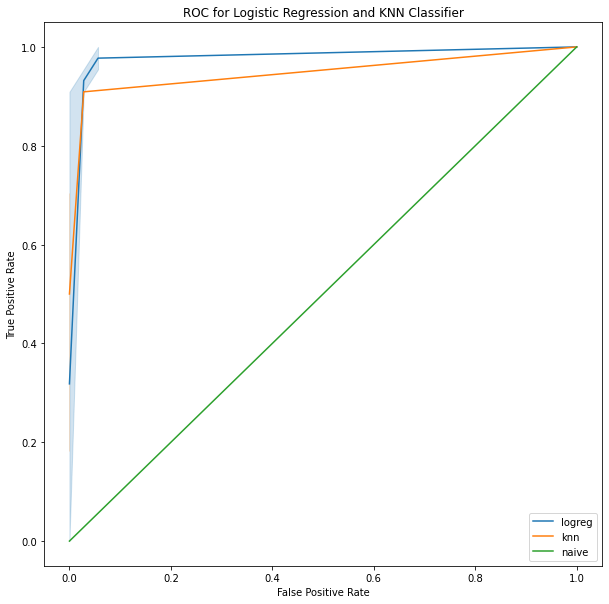

In [19]:
sns.lineplot(fpr_lr,tpr_lr)
sns.lineplot(fpr_knn,tpr_knn)
sns.lineplot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['logreg','knn','naive'])
plt.title('ROC for Logistic Regression and KNN Classifier')